# How does MLOOP work?

Created by Valerio. I took all the mathematical derivations from [this reference](https://gaussianprocess.org/gpml/chapters/RW.pdf).

[MLOOP](https://m-loop.readthedocs.io/en/latest/api/mloop.html) (Machine Learning Online Optimization Protocol) is an open-source Python package that allows fast optimisation of the lab's parameters ([here the main paper](https://www.nature.com/articles/srep25890)).
We recently used it in our lab, and it has demonstrated excellent capabilities. MLOOP can explore a space of 8 parameters in less than 100 iterations. If one wants to perform an 8-dimentional scan (the usual np.linspace scan) with 10 points for each parameter, a $10^{8}$ runs would be required, which is definitely inconvenient compare to MLOOP. (see the reference for more).

#### The MLOOP algoritm in 4 simple steps:
  1) We choose (or extract randomically) the parameters for the first run $X^1=[x_1^1, x_2^1, ..,x_m^1]$, where $m$ is the number of parameters, and run the experiment.
  2) We compute the *cost* $C^1=f(X^1)$, which is a function of the experiment results, that we want to minimize (for example minus the number of atoms), and give it to MLOOP.
  3) MLOOP iterates (a choosen number of times) on the following:
      * Calls an algoritm (*learner*) that returns a preditction for a function that describes the data stored until now (parameters, cost).
      * Based on this prediction it decides (*acquisition function*) the parameters for the next run.
      * Run the experiment and stores the new cost and parameters.
  4) Returns the minima $(X_{min})$ of the last predicted function.

The *learners* implemented by MLOOP icludes Gaussian Process Regression (GPR), Neural Networks, Nelder Mead, and Differential Evolution.

Here, I show how the Gaussian Process Regrssion works. It is the default method used by MLOOP, and also the method we used in our optimizations.
Then I will define the *acquisition fucntion* used in MLOOP and show some examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gaussian Process

In a Gaussian Process the distribution $p(f(X))$ is be defined as follow:
* $f_{\mu}(X)=E[f(X)]$. If I extract many functions from this distribution and mean on their value in $X$, I will get $f_{\mu}(X)$.
* $cov(X^1,X^2) = E[(f(X^1)-f_{\mu}(X^1))(f(X^2)-f_{\mu}(X^2))]=k(X^1,X^2)$. $k(X^1,X^2)$ is called *kernel*. Depending on the choice of the kernel you can impose some properties to the functions described by the model. For example if we impose $k(X^1,X^2,H) = e^{-\sum_{i=1}^m(X^1_i-X^2_i)^2/h_i^2}$ we are imposing a gaussian spatial correlation for each considered parameter. In other words we are imposing the functions to be smooth and $h_i$ is the *"smoothness"* of the $i^{th}$ parameter. $H=[h_1,..h_m]$.

In [2]:
# define here the function that describes the mean value of the distribution for a given X. 
# the sine is choosen as example, can be any function.
def f_mu(_x):
    return np.sin(_x)

# define the kernel here
def kernel(_x1, _x2, _h):
    return np.exp(-(_x1-_x2)**2/_h**2)

### Example: extraction of two GP (with 2 different correlation lengths), for a given model
* 1D parameter space: $X^i=[x^i_1]$. The $i$ indexes on the experiment runs. 
* $f_{\mu}(X^i) = \sin(X^i)$.
* $k(X^i,X^j,h) = e^{-(X^i-X^j)^2/h^2}$

If we want to extract 100 points, $\{X^i, C^i\}$, with $i=[1, ..,100]$, we have to compute a vector with 100 elements for $f_{\mu}(X^i)$ and a matrix 100x100 for $cov(X^i,X^j)$. Than we can extract from a multivariate normal distribution ([see section A2](https://gaussianprocess.org/gpml/chapters/RW.pdf)) the 100 points that will rapresent a sample from the functions space.

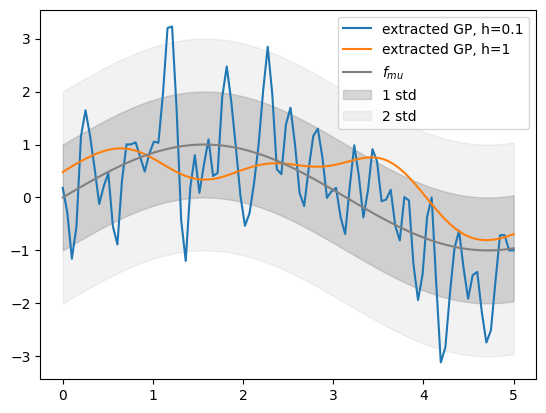

In [3]:
domine = [0,5] # define the parameter range here
correlation_length = 0.2 # define the correlation lenght or "smoothness" here.
n_samples = 100 # numer of point for line

parameter_samples = np.linspace(domine[0], domine[1], n_samples) # these are the X^i

def get_means_and_covs(parameter_samples, correlation_length):
    n_samples = len(parameter_samples)
    means = np.array([f_mu(parameter_value) for parameter_value in parameter_samples]) # these are the f_mu(X^i)
    cov = np.zeros([n_samples, n_samples]) # these are the cov(X^i,X^j)

    for i in range(n_samples):
        for j in range(n_samples):
            cov[i,j] = kernel(parameter_samples[i], parameter_samples[j], correlation_length) # compute all the matrix elements of the covariance matrix.
    return means, cov

# extract two samples with different correlation length, to show the difference.
for correlation_length in [0.1,1]:
    means, cov = get_means_and_covs(parameter_samples, correlation_length)
    costs = np.random.multivariate_normal(means, cov)

    plt.plot(parameter_samples, costs, label=f"extracted GP, h={correlation_length}")

plt.plot(parameter_samples, means, color="gray", label=r"$f_{mu}$")
plt.fill_between(parameter_samples, means+np.diag(cov), means-np.diag(cov), color="grey", alpha=0.3, label="1 std")
plt.fill_between(parameter_samples, means+2*np.diag(cov), means-2*np.diag(cov), color="grey", alpha=0.1, label="2 std")
plt.legend()

plt.show()

## Gaussian Process Regression

Let's consider our data: $[X^i=(x_1^i,..x_m^i),C^i]$, where $X^i, C^i$ are parameters and cost of the $i^{th}$ iteration.
If one wants to find a prediction of the minima could try to find a function to fit the data and then minimixe the best fit to predict the minima. 
You alredy see that the problem with this approach is that it may actually be really hard to define a function of the cost versus all the parameters. Using GPR is someway possible to perform a "fit" without defining any fit function.
The idea of GPR is to consider a GP and someway include the information of the experimental data, in other words we want to constraint the GP to pass close to our datapoints.

To do this we can consider the joint distribution of datapoints and test points, which is a multivariate normal, and from it compute the conditional distribution of the test points given the datapoints (this part is well explained [here, section A2](https://gaussianprocess.org/gpml/chapters/RW.pdf)).
It results that the conditional distribution is still a multivariate normal (MN)
$$ p(C_{t}|X_{t}, X_{exp}, C_{exp}, \sigma^2_{exp}) = MN(\bar{C_t}, cov({C_t})) $$ 
where $C_{t}, X_{t}$ are the test points (the points of an extracted sample, as in the example above). $X_{exp}, C_{exp}, \sigma^2_{exp} = \{[X^i=(x_1^i,..x_m^i),C^i, \sigma^2_{i}], \ i=(1,..n)\}$ are the $n$ experimental data ($\sigma^2_{i}$ is the uncertainties (variance) associated to $C^i$). And
$$
\bar{C_t} = K(X_{t},X_{exp})[K(X_{exp},X_{exp}) + \sigma_{exp}^2 I]^{-1}C_{exp}
\\
cov({C_t}) = K(X_{t},X_{t}) - K(X_{t},X_{exp})[K(X_{exp},X_{exp}) + \sigma_{exp}^2 I]^{-1}K(X_{exp},X_{t})
$$
Where $[K(X,Y)]_{ij} = k(x_i,y_j)$ ($k$ is the kernel defined above), $I$ is the identity $n\times n$. 

### example with two datapoints:
* 1D parameter space: $X^i=[x^i_1]$. The $i$ indexes on the experiment runs. 
* $f_{\mu}(X^i) = 0$. We use a flat function: no prior knowledge.
* $k(X^i,X^j,h) = e^{-(X^i-X^j)^2/h^2}$

In [4]:
# define here the function that describes the mean value of the distribution for a given X. 
# the sine is choosen as example, can be any function.
def f_mu(_x):
    return 0

def get_K(_X1, _X2, correlation_length):
    # compute the matrix K(X1,X2,H)
    _K = np.zeros([len(_X1), len(_X2)])
    
    for i in range(len(_X1)):
        for j in range(len(_X2)):
            _K[i,j] = kernel(_X1[i], _X2[j], correlation_length)
    return _K

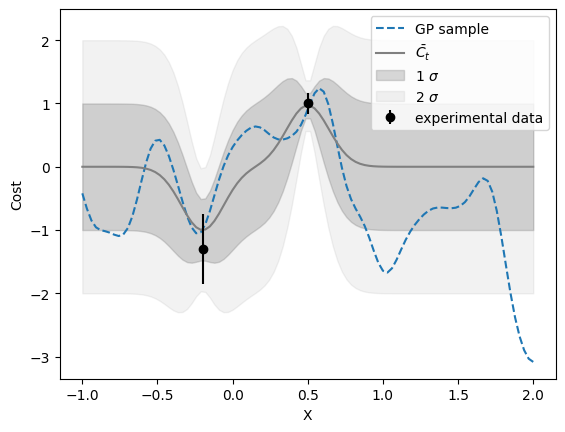

In [5]:
domine = [-1,2] # define the parameter range here

# define the datapoints
X_exp = np.array([0.5, -0.2])
C_exp = np.array([1, -1.3])
sigma2 = np.array([0.03, 0.3])

correlation_length = 0.2 # define the correlation lenght or "smoothness" here.
n_samples = 100 # numer of point for line

X_test = np.linspace(domine[0], domine[1], n_samples) # these are the X_t

# compute all the matrices K
K_te = get_K(X_test, X_exp, correlation_length)
K_ee = get_K(X_exp, X_exp, correlation_length)
K_tt = get_K(X_test, X_test, correlation_length)
K_et = K_te.T

# compute mean and cov of the conditioned probability distribution (see text above)
C_mean_test = K_te.dot(np.linalg.inv(K_ee + np.diag(sigma2)).dot(C_exp))
cov_C_t = K_tt - K_te.dot(np.linalg.inv(K_ee + np.diag(sigma2)).dot(K_et))

# extract a GP sample from the multivariate normal distribution
C_test = np.random.multivariate_normal(C_mean_test, cov_C_t)

# plot
plt.plot(X_test, C_test, label=f"GP sample", linestyle="--")
plt.plot(X_test, C_mean_test, color="gray", label=r"$\bar{C_t}$")
plt.fill_between(X_test, C_mean_test+np.diag(cov_C_t)**.5, C_mean_test-np.diag(cov_C_t)**.5, color="grey", alpha=0.3, label=f"1 $\sigma$")
plt.fill_between(X_test, C_mean_test+2*np.diag(cov_C_t)**.5, C_mean_test-2*np.diag(cov_C_t)**.5, color="grey", alpha=0.1, label=f"2 $\sigma$")
plt.errorbar(X_exp, C_exp, sigma2**.5, label="experimental data", linestyle="", marker="o", color="black")
plt.xlabel("X")
plt.ylabel("Cost")
plt.legend()

plt.show()

## How does it choose the next point?

So, using the GPR, we get $\bar{C_t}$ and $cov({C_t})$, which contain all the information of the data.
Now, from them we want to choose the parameter value for the next run. 
note the following.
* $\bar{C_t}$ is the mean value for each $X$. The maximum of this function is a good candidate for the next run if we want to maximize the cost. The problem is that we can be in a local minima, without exploring all the space.
* the diagonal of $cov({C_t})$ (we call it $\Sigma_t(X)$) contains the variance for each $X$. In this case the maximim will identify the point where we have less knowledge (maximum variance). If we use this as next point we could spend all the time exploring new regions, without converging in any maxima.

There are many way to define an *acquisition function*, in MLOOP they define a *biased function* to choose the next point ([read this for more](https://www.nature.com/articles/srep25890)), as follows:
$$
B(X) = b \bar{C_t}(X) + (1-b)\Sigma_t(X) \\
X_{next} = \max(B(X))
$$

With $b$ a number between 0 and 1. During the optimization $b$ linearly increases form 0 to 1. It means that at the beginning it will explore the regions with less knowledge, and at the end it will focus on the maximum.

In [6]:
# define here the biased function
def biased_function(means, cov, b):
    return - b*means + (1-b)*np.diag(cov)

# Experiment simulation

Let's consider a fake experiment

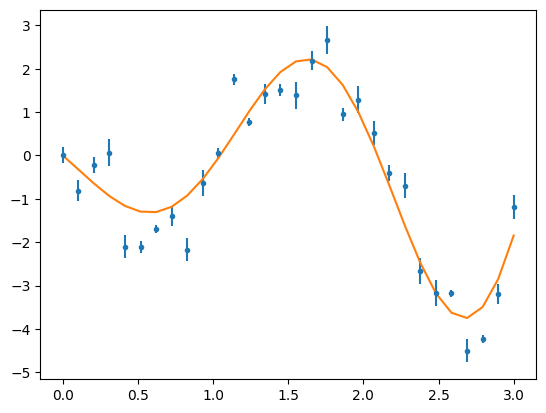

In [7]:
def run_fake_experiment(parameter, std=0):
    cost = -np.sin(3*parameter)*np.exp(.5*parameter) + np.random.normal(0, std)
    variance = np.random.uniform(std/100, std/5)
    return cost, variance

domine = [0,3]
X_exp = np.linspace(domine[0], domine[1], 30)
C_exp = np.zeros(len(X_exp))
sigma2 = np.zeros(len(X_exp))
for i, x in enumerate(X_exp):
    C_exp[i], sigma2[i] = run_fake_experiment(x, std=0.5)

plt.errorbar(X_exp, C_exp, sigma2**.5, linestyle="", marker=".")
y_ideal, _ = run_fake_experiment(X_exp)
plt.plot(X_exp, y_ideal)
plt.show()

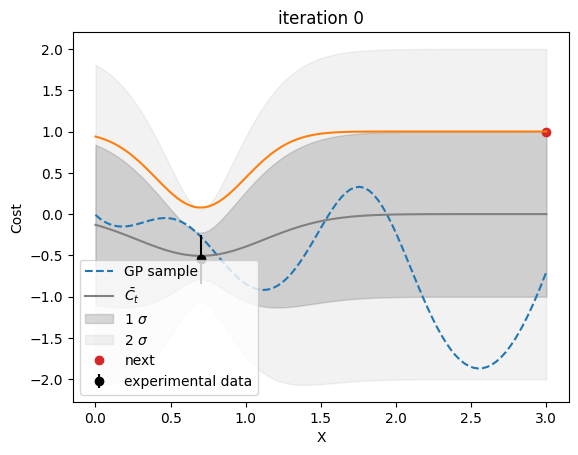

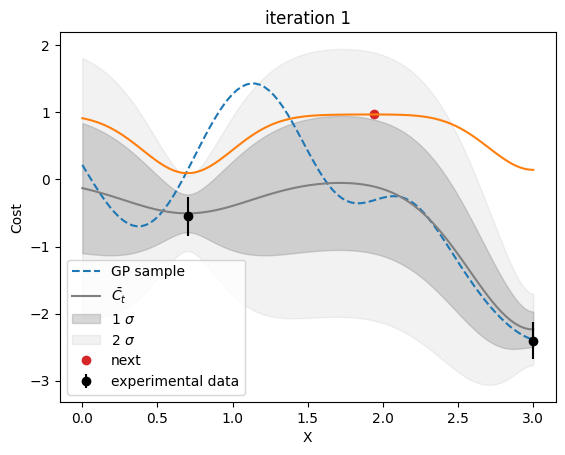

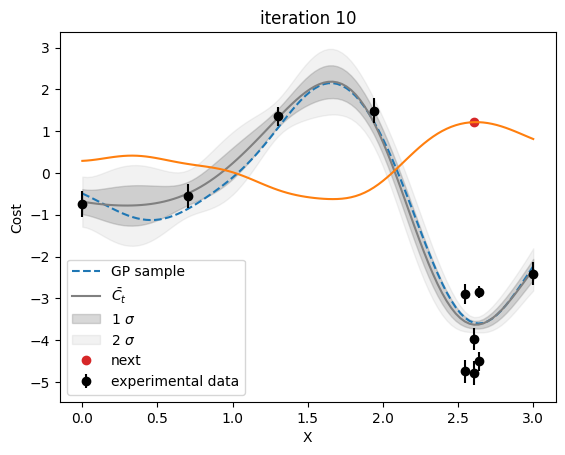

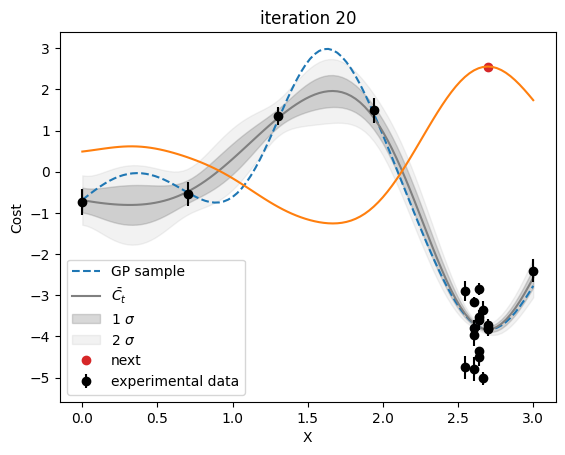

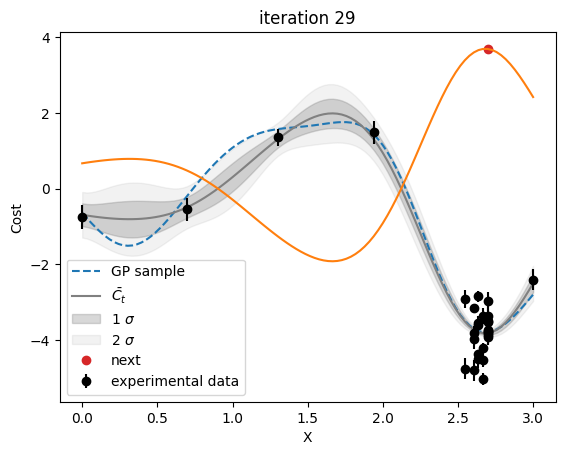

In [8]:

n_iterations = 30
plot_iterations = [0,1,10,20,29]
correlation_length = 0.6 # define the correlation lenght or "smoothness" here.
n_samples_test = 100 # numer of point for line

# define the test points, (the X_t)
X_test = np.linspace(domine[0], domine[1], n_samples_test)

# initial point
X_next = 0.7

# define an arbitrary noise on the experiment
std_experiment = 0.5

# define empty lists
X_exp = []
C_exp = []
sigma2 = []

for i in range(n_iterations):
    ###################################################################
    # run the experiment and get the cost, with associated uncertainty
    C_new, sigma2_new = run_fake_experiment(X_next, std_experiment) 
    X_exp.append(X_next)
    C_exp.append(C_new)
    sigma2.append(sigma2_new)

    ##################################################################
    # decide the next point

    # computes all the matrices K
    K_te = get_K(X_test, X_exp, correlation_length)
    K_ee = get_K(X_exp, X_exp, correlation_length)
    K_tt = get_K(X_test, X_test, correlation_length)
    K_et = K_te.T

    # computes mean and cov of the conditioned probability distribution (see text above)
    C_mean_test = K_te.dot(np.linalg.inv(K_ee + np.diag(sigma2)).dot(C_exp))
    cov_C_t = K_tt - K_te.dot(np.linalg.inv(K_ee + np.diag(sigma2)).dot(K_et))

    # define the weight b, for the biased funtion
    b = i/n_iterations

    # compute the biased function
    B = biased_function(C_mean_test, cov_C_t, b)

    X_next_index = np.argmax(B)
    X_next = X_test[X_next_index]
        
    if i in plot_iterations:
        # extract a GP sample from the multivariate normal distribution
        C_test = np.random.multivariate_normal(C_mean_test, cov_C_t)

        # plot
        plt.plot(X_test, C_test, label=f"GP sample", linestyle="--")
        plt.plot(X_test, C_mean_test, color="gray", label=r"$\bar{C_t}$")
        plt.fill_between(X_test, C_mean_test+np.diag(cov_C_t)**.5, C_mean_test-np.diag(cov_C_t)**.5, color="grey", alpha=0.3, label=f"1 $\sigma$")
        plt.fill_between(X_test, C_mean_test+2*np.diag(cov_C_t)**.5, C_mean_test-2*np.diag(cov_C_t)**.5, color="grey", alpha=0.1, label=f"2 $\sigma$")
        plt.errorbar(X_exp, C_exp, np.array(sigma2)**.5, label="experimental data", linestyle="", marker="o", color="black")
        plt.plot(X_next, B[X_next_index], color="tab:red", label="next", linestyle="", marker="o")
        plt.plot(X_test, B)
        plt.xlabel("X")
        plt.ylabel("Cost")
        plt.title(f"iteration {i}")
        plt.legend()

        plt.show()